# Data Analysis of Yelp Dataset:
### Finding ideal location for a new restaurant

#### By Swanand Barsawade (825876097)

#### Objective
I wanted to find insights by using existing yelp data to help existing business owners, future business owners to make important decisions regarding new business or business expansion.40% of world population has internet connection today compared to 1% in 1995. Almost 3 exabytes of data is created per day using internet. Storing huge amount of data and retrieving knowledge out of it is challenging task these days and that's where Yelp comes into picture to provide data about businesses along with their reviews, ratings, etc.

#### Dataset information:
The yelp data set has 4 entities namely Business, Review, User and Checkin. I have used business and reviews files among this dataset.
1. Business entity has unique key business_id with 15 columns of information like name, nighborhood, address, city, state, etc. of businesses and 15,707 rows for restaurants.
2. Review enity has unique key review_id and has 100,000 rows and about 9 columns about stars, date, text, etc.

#### Readme

Steps to run the project:

1) Please create your own Google API key by following this documentation:(http://jupyter-gmaps.readthedocs.io/en/latest/authentication.html
After creating the key, please assign the api key to variable 'key' in the first cell.

2) Please store both the json (business.json and review.json) and ipynb files in the same folder.

3) Please run the following command,
<br>!pip3 install plotly
<br>!pip3 install gmaps
<br>!pip3 install matplotlib
<br>!pip3 install seaborn
<br>!pip3 install scikit-learn

4) Please click on run-all cells option and it takes about 10 mins to run the entire file and to plot all the visualizations in it.

5) Please enter a valid zip code and category of restaurant when asked to enter

In [ ]:
key = "" #Enter your api key here

## Importing all the required packages

In [ ]:
import datetime
import numpy as np
import pandas as pd
import json
import re

# Data Visualization packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
pd.set_option('mode.chained_assignment', None)
pd.set_option('max_colwidth', 50)
import plotly.offline as py
py.init_notebook_mode(connected=False)
import plotly.graph_objs as go

# Styling for matplotlib.
%matplotlib inline
plt.style.use('tableau-colorblind10')

import seaborn as sns
sns.set()
sns.set_context("talk")

# Imports for google maps and GCP gmaps api key
import gmaps
import gmaps.datasets
gmaps.configure(api_key=key)  # Use your google API key

# Imports for kmeans and linear Model for classification and prediction
import utils
import kmeans
from sklearn.model_selection import train_test_split
import sklearn.linear_model

# Imports collections to analyze sequences
import collections
collections.Iterable = collections.abc.Iterable
collections.Sequence = collections.abc.Sequence

import os

# Imports warnings to avoid future warnings in code
import warnings
warnings.filterwarnings('ignore')

Reading business and Reviews dataset into a pandas dataframe

In [ ]:
reviews = pd.DataFrame.from_records(utils.load_file('dataset/review.json'))
business =  pd.DataFrame.from_records(utils.load_file('dataset/business.json'))

# Data Cleaning and Preprocessing

In [ ]:
reviews.drop(columns=['useful','funny','cool']).head().T

0  \
review_id                               v0i_UHJMo_hPBq9bxWvW4w   
user_id                                 bv2nCi5Qv5vroFiqKGopiw   
business_id                             0W4lkclzZThpx3V65bVgig   
stars                                                        5   
date                                                2016-05-28   
text         Love the staff, love the meat, love the place....   

                                                             1  \
review_id                               vkVSCC7xljjrAI4UGfnKEQ   
user_id                                 bv2nCi5Qv5vroFiqKGopiw   
business_id                             AEx2SYEUJmTxVVB18LlCwA   
stars                                                        5   
date                                                2016-05-28   
text         Super simple place but amazing nonetheless. It...   

                                                             2  \
review_id                               n6QzIUObkYshz4dz2QRJTw   
user_id                                 bv2nCi5Qv5vroFiqKGopiw   
business_id                             VR6GpWIda3SfvPC-lg9H3w   
stars                                                        5   
date                                                2016-05-28   
text         Small unassuming place that changes their menu...   

                                                             3  \
review_id                               MV3CcKScW05u5LVfF6ok0g   
user_id                                 bv2nCi5Qv5vroFiqKGopiw   
business_id                             CKC0-MOWMqoeWf6s-szl8g   
stars                                                        5   
date                                                2016-05-28   
text         Lester's is located in a beautiful neighborhoo...   

                                                             4  
review_id                               IXvOzsEMYtiJI0CARmj77Q  
user_id                                 bv2nCi5Qv5vroFiqKGopiw  
business_id                             ACFtxLv8pGrrxMm6EgjreA  
stars                                                        4  
date                                                2016-05-28  
text         Love coming here. Yes the place always needs t...

Checking the column names from the business dataframe

In [ ]:
business.columns

Index(['business_id', 'name', 'neighborhood', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count',
       'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')

Filtering all the categories that contains restaurants from the business dataframe

In [ ]:
rest_business = business[business.categories.astype(str).str.lower().str.contains('restaurant')]
rest_business.shape

(15707, 15)

Merging reviews and filtered business dataframe on business_id column

In [ ]:
restaurant = reviews.merge(rest_business, on = 'business_id',suffixes=(' review',' business'))
restaurant.head(1)

review_id                 user_id             business_id  \
0  MV3CcKScW05u5LVfF6ok0g  bv2nCi5Qv5vroFiqKGopiw  CKC0-MOWMqoeWf6s-szl8g   

   stars review        date  \
0             5  2016-05-28   

                                                text  useful  funny  cool  \
0  Lester's is located in a beautiful neighborhoo...       0      0     0   

            name  ... state postal_code   latitude  longitude stars business  \
0  Lester's Deli  ...    QC     H2V 1V1  45.522144 -73.607076            4.0   

   review_count  is_open                                         attributes  \
0            70        1  {'RestaurantsTableService': True, 'GoodForMeal...   

                                          categories  \
0  [Specialty Food, Food, Sandwiches, Restaurants...   

                                               hours  
0  {'Monday': '9:00-21:00', 'Tuesday': '9:00-21:0...  

[1 rows x 23 columns]

Counting the values of each state in the dataframe

In [ ]:
restaurant['state'].value_counts()

NV     5777
AZ     5183
ON     2632
NC     1187
OH      967
PA      811
QC      523
WI      513
EDH     133
IL      116
BW      109
SC       49
MLN      12
HLD       5
KHL       1
Name: state, dtype: int64

1. Fetching only categories from the merged dataframe ater replacing `Restaurants` with an empty string, `Fast Food` with `Fast_Fd` and `Food` with an empty string.
2. Creating a comma separated string `business_cats` with only categories from the merged dataframe. Creating a new dataframe of categories, skipping all the empty string.

In [ ]:
restaurant['categories'] = (restaurant['categories'].astype(str)
                     .str.replace('Restaurants', '')
                     .str.replace('Fast Food', 'Fast_Fd')
                     .str.replace('Food', ''))
business_cats = ', '.join(restaurant['categories'].dropna())
cats = pd.DataFrame(business_cats.split(', '), columns=['category'])
cats = cats[cats != '']

len(cats)

81838

In [ ]:
cats.head()

category
0  ['Specialty '
1             ''
2   'Sandwiches'
3             ''
4      'Burgers'

Creating a comma separated string from the merged dataframe and creating a dataframe from the string, creating a series of all the category count then converting it into a dataframe. Resetting its index to get a numerical index instead of categories.  

In [ ]:
business_cats = ', '.join(restaurant['categories'].dropna())
cats = pd.DataFrame(business_cats.split(', '), columns=['category'])
cats_ser = cats.category.value_counts()
cats_df = pd.DataFrame(cats_ser)
cats_df.reset_index(inplace=True)
cats_df.head()

index  category
0           ''     10211
1          '']      5811
2          [''      5788
3  'Nightlife'      2773
4       'Bars'      2710

Fetching first 20 unique categories excluding an empty string, Cocktail Bars and Sushi Bar


In [ ]:
cats_df = cats_df[cats_df['category'] != '']
cats_df = cats_df[cats_df['category'] != 'Cocktail Bars']
cats_df = cats_df[cats_df['category'] != 'Sushi Bars']
cat_to_keep = cats_df.head(20)['category'].unique()
cat_to_keep

array([10211,  5811,  5788,  2773,  2710,  1816,  1732,  1493,   951,
         832,   769,   762,   742,   732,   702,   673,   648,   629,
         616])

# Exploratory Data Analysis

Creating a Star Rating Distribution from the dataset to explore different stars received by the number of businesses

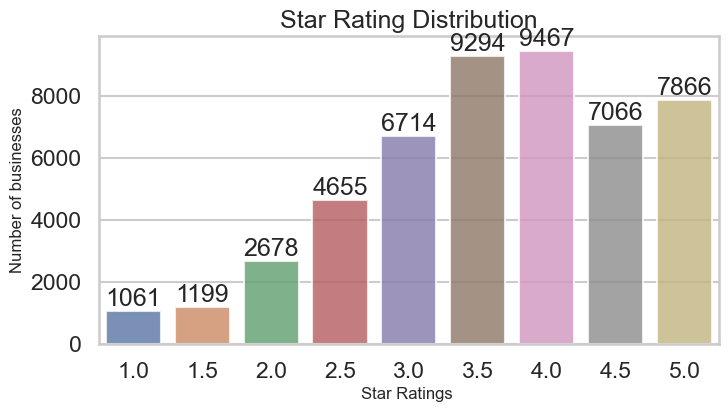

In [ ]:
#prep for chart
color = sns.color_palette()
sns.set_style("whitegrid")

#Get the distribution of the ratings
x = business['stars'].value_counts()
x = x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')

plt.show()

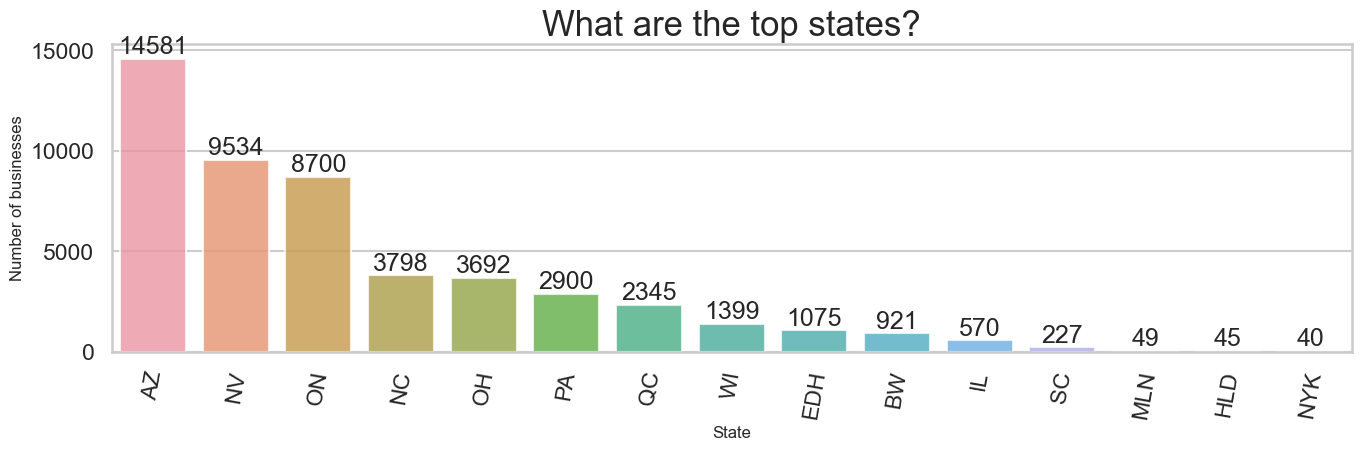

In [ ]:
#prep for chart
x = business['state'].value_counts()
x = x.sort_values(ascending=False)
x = x.iloc[0:15]

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("What are the top states?", fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('State', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')

plt.show()

Visualizing the states data. According to the analysis, Arizona (AZ) is one of the most popular state from the United States on YELP

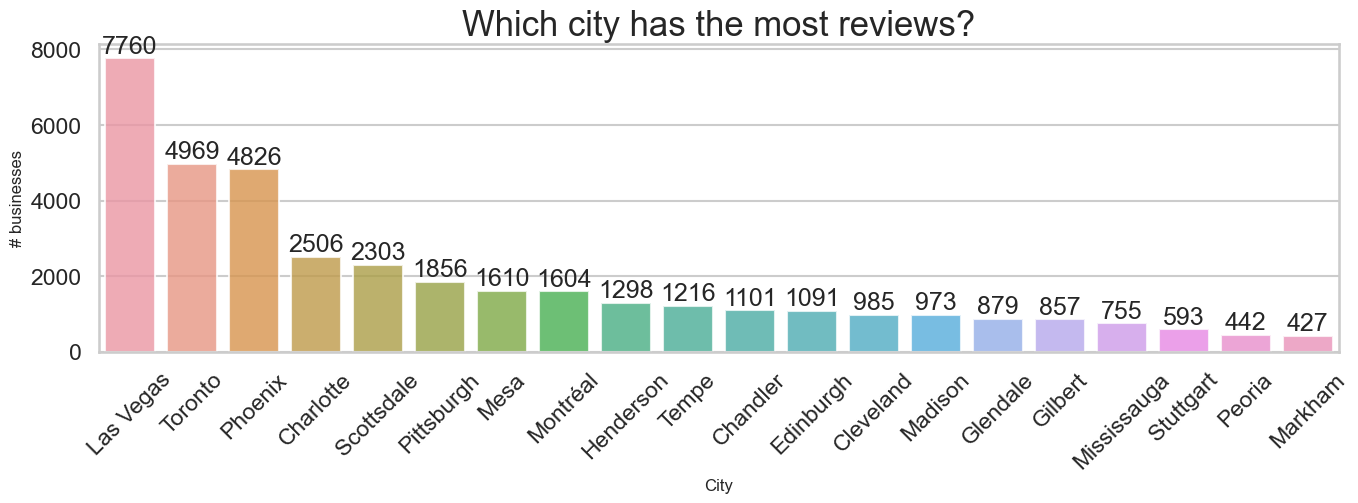

In [ ]:
#Get the distribution of the ratings
x = business['city'].value_counts()
x = x.sort_values(ascending=False)
x = x.iloc[0:20]

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Which city has the most reviews?", fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('City', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')

plt.show()

In [ ]:
restaurant['date'] = pd.to_datetime(restaurant['date'])

Analayzing Monthly reviews to get the month in which businesses receive most customers. According to our analysis July is preferred more by the people to visit.

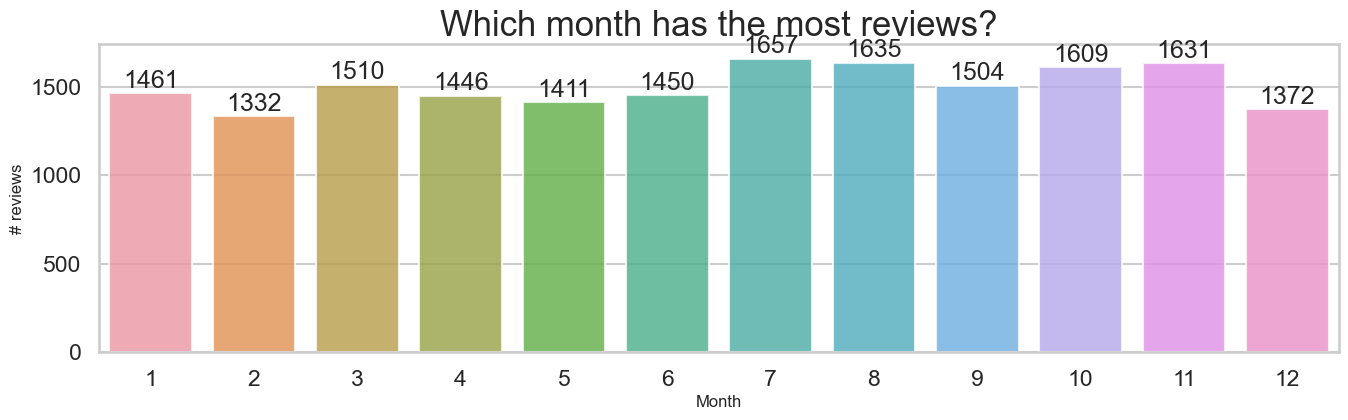

In [ ]:
#Get the distribution of the reviews by month
x = restaurant.groupby(restaurant['date'].dt.month)['business_id'].count()

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Which month has the most reviews?", fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.ylabel('# reviews', fontsize=12)
plt.xlabel('Month', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')

plt.show()

## Restaurant distribution

In [ ]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [ ]:
business.name=business.name.str.replace('"','')
business.address=business.address.str.replace('"','')

Fetching only USA related data as our analysis is limited to the united states

In [ ]:
usa=business.loc[business['state'].isin(states)]
usa.head()

business_id                      name neighborhood  \
0  FYWN1wneV18bWNgQjJ2GNg          Dental by Design                
1  He-G7vWjzVUysIKrfNbPUQ       Stephen Szabo Salon                
2  KQPW8lFf1y5BT2MxiSZ3QA     Western Motor Vehicle                
3  8DShNS-LuFqpEWIp0HxijA          Sports Authority                
4  PfOCPjBrlQAnz__NXj9h_w  Brick House Tavern + Tap                

                          address            city state postal_code  \
0        4855 E Warner Rd, Ste B9       Ahwatukee    AZ       85044   
1              3101 Washington Rd        McMurray    PA       15317   
2          6025 N 27th Ave, Ste 1         Phoenix    AZ       85017   
3  5000 Arizona Mills Cr, Ste 435           Tempe    AZ       85282   
4                    581 Howe Ave  Cuyahoga Falls    OH       44221   

    latitude   longitude  stars  review_count  is_open  \
0  33.330690 -111.978599    4.0            22        1   
1  40.291685  -80.104900    3.0            11        1   
2  33.524903 -112.115310    1.5            18        1   
3  33.383147 -111.964725    3.0             9        0   
4  41.119535  -81.475690    3.5           116        1   

                                          attributes  \
0  {'AcceptsInsurance': True, 'ByAppointmentOnly'...   
1  {'BusinessParking': {'garage': False, 'street'...   
2                                                 {}   
3  {'BusinessAcceptsCreditCards': True, 'Restaura...   
4  {'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...   

                                          categories  \
0  [Dentists, General Dentistry, Health & Medical...   
1  [Hair Stylists, Hair Salons, Men's Hair Salons...   
2  [Departments of Motor Vehicles, Public Service...   
3                         [Sporting Goods, Shopping]   
4  [American (New), Nightlife, Bars, Sandwiches, ...   

                                               hours  
0  {'Friday': '7:30-17:00', 'Tuesday': '7:30-17:0...  
1  {'Monday': '9:00-20:00', 'Tuesday': '9:00-20:0...  
2                                                 {}  
3  {'Monday': '10:00-21:00', 'Tuesday': '10:00-21...  
4  {'Monday': '11:00-1:00', 'Tuesday': '11:00-1:0...

Dropping all the null values from the categories field

In [ ]:
usa = usa.dropna(subset=['categories'])

Fetching only `restaurants` data. As, our initial analysis and recommendation is limited to the `United States` which can be expanded in future.

In [ ]:
us_restaurants=usa[usa['categories'].astype(str).str.contains('Restaurants')]

Assigning category to the type of restaurants based on the type mentioned in the general categories.

In [ ]:
us_restaurants.is_copy=False
us_restaurants['category']=pd.Series()

us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('American'),'category'] = 'American'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('Mexican'), 'category'] = 'Mexican'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('Italian'), 'category'] = 'Italian'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('Japanese'), 'category'] = 'Japanese'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('Chinese'), 'category'] = 'Chinese'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('Thai'), 'category'] = 'Thai'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('Mediterranean'), 'category'] = 'Mediterranean'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('French'), 'category'] = 'French'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('Vietnamese'), 'category'] = 'Vietnamese'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('Greek'),'category'] = 'Greek'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('Indian'),'category'] = 'Indian'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('Korean'),'category'] = 'Korean'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('Hawaiian'),'category'] = 'Hawaiian'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('African'),'category'] = 'African'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('Spanish'),'category'] = 'Spanish'
us_restaurants.loc[us_restaurants.categories.astype(str).str.contains('Middle_eastern'),'category'] = 'Middle_eastern'


In [ ]:
us_restaurants.dropna(inplace=True)
us_restaurants

business_id                           name  \
4      PfOCPjBrlQAnz__NXj9h_w       Brick House Tavern + Tap   
14     fNMVV_ZX7CJSDWQGdOM8Nw     Showmars Government Center   
29     gAy4LYpsScrj8POnCW6btQ                     Toast Cafe   
40     tRVx2c89coruPRwYhGTcTw                           Yuzu   
44     BnuzcebyB1AfxH0kjNWqSg       Carrabba's Italian Grill   
...                       ...                            ...   
49969  kWkW6vVePpBox_fKfGgPjQ  Pan Asia Sushi Chinese Fusion   
49977  SeMczUVuKhVwruoJfrThtQ           El Rincon Sinaloense   
49980  r4RCtOZxp0nXpuoN_Usd1w                   India Darbar   
49984  L8xcyoyugR6xK1QmBkyfyg      Yatai Ramen AZ Food Truck   
49991  2tfMXjOotr1r168mVttUmQ                     Local West   

           neighborhood                      address            city state  \
4                                       581 Howe Ave  Cuyahoga Falls    OH   
14               Uptown                 600 E 4th St       Charlotte    NC   
29                                    2429 Hwy 160 W       Fort Mill    SC   
40                                 13603 Madison Ave        Lakewood    OH   
44                                 245 Lancaster Ave          Frazer    PA   
...                 ...                          ...             ...   ...   
49969                    2485 E Baseline Rd, Ste 157         Phoenix    AZ   
49977                        7540 W Indian School Rd         Phoenix    AZ   
49980                                  6119 Odana Rd         Madison    WI   
49984                                 7601 E Gray Rd      Scottsdale    AZ   
49991  Detroit-Shoreway             7400 Detroit Ave       Cleveland    OH   

      postal_code   latitude   longitude  stars  review_count  is_open  \
4           44221  41.119535  -81.475690    3.5           116        1   
14          28202  35.221647  -80.839345    3.5             7        1   
29          29708  35.047287  -80.990559    3.5             6        0   
40          44107  41.476846  -81.786971    3.5            78        1   
44          19355  40.041003  -75.542497    3.5            25        0   
...           ...        ...         ...    ...           ...      ...   
49969       85042  33.377114 -112.027889    3.0            91        0   
49977       85033  33.495713 -112.222228    4.0             9        1   
49980       53774  43.052940  -89.486185    4.5             6        0   
49984       85260  33.611970 -111.916909    4.0            15        1   
49991       44102  41.482919  -81.735620    4.0            95        1   

                                              attributes  \
4      {'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...   
14     {'GoodForMeal': {'dessert': False, 'latenight'...   
29     {'GoodForMeal': {'dessert': False, 'latenight'...   
40     {'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...   
44     {'RestaurantsTableService': True, 'GoodForMeal...   
...                                                  ...   
49969  {'RestaurantsTableService': True, 'GoodForMeal...   
49977  {'GoodForMeal': {'dessert': False, 'latenight'...   
49980  {'GoodForMeal': {'dessert': False, 'latenight'...   
49984  {'GoodForMeal': {'dessert': False, 'latenight'...   
49991  {'RestaurantsTableService': False, 'GoodForMea...   

                                              categories  \
4      [American (New), Nightlife, Bars, Sandwiches, ...   
14                 [Restaurants, American (Traditional)]   
29     [Food, American (Traditional), Coffee & Tea, R...   
40     [Nightlife, Izakaya, Comfort Food, Cocktail Ba...   
44                       [Restaurants, Italian, Seafood]   
...                                                  ...   
49969                 [Sushi Bars, Chinese, Restaurants]   
49977  [Tacos, Breakfast & Brunch, Fast Food, Mexican...   
49980                   [Restaurants, Indian, Pakistani]   
49984  [Ramen, Food Trucks, Restaurants, Japanese, Food]   
49991  [Burgers, Restaurants, American (Tr

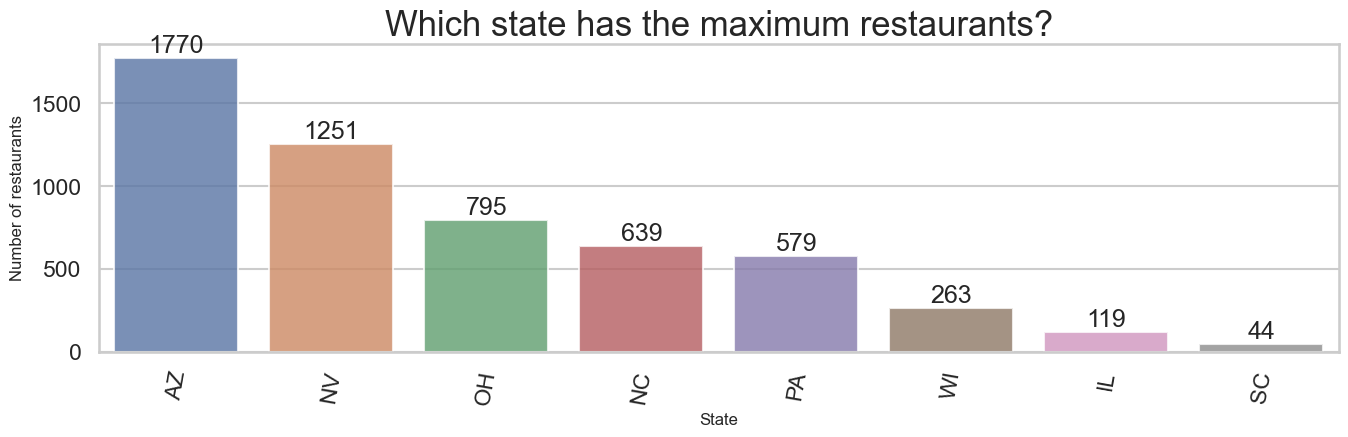

In [ ]:
#prep for chart
x = us_restaurants['state'].value_counts()
x = x.sort_values(ascending=False)
x = x.iloc[0:15]

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Which state has the maximum restaurants?", fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('Number of restaurants', fontsize=12)
plt.xlabel('State', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')

plt.show()

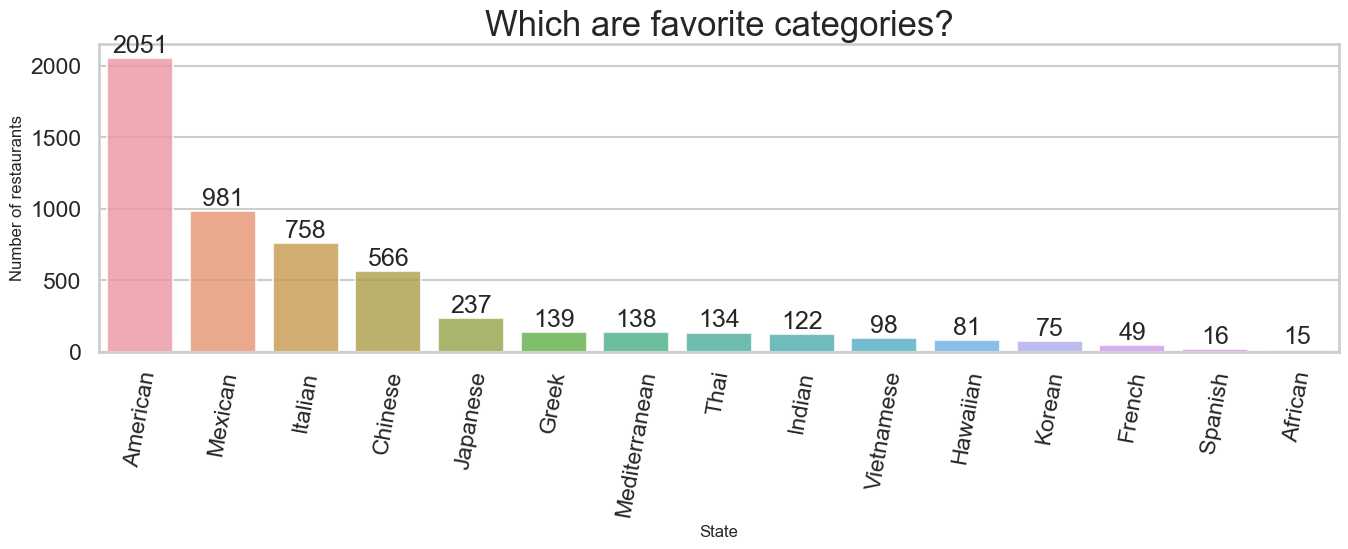

In [ ]:
#prep for chart
x = us_restaurants['category'].value_counts()
x = x.sort_values(ascending=False)
x = x.iloc[0:15]

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Which are favorite categories?", fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('Number of restaurants', fontsize=12)
plt.xlabel('State', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')

plt.show()

## Phase 1:  Reviews

Phase 1 is the analysis to filter reviews into positive, negative and neutral based on the text data in the reviews column

In [ ]:
reviews = reviews[['review_id', 'date', 'stars', 'text', 'cool', 'funny', 'useful', 'business_id', 'user_id']]
reviews['date'] = reviews['date'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d'))
reviews.head()

review_id       date  stars  \
0  v0i_UHJMo_hPBq9bxWvW4w 2016-05-28      5   
1  vkVSCC7xljjrAI4UGfnKEQ 2016-05-28      5   
2  n6QzIUObkYshz4dz2QRJTw 2016-05-28      5   
3  MV3CcKScW05u5LVfF6ok0g 2016-05-28      5   
4  IXvOzsEMYtiJI0CARmj77Q 2016-05-28      4   

                                                text  cool  funny  useful  \
0  Love the staff, love the meat, love the place....     0      0       0   
1  Super simple place but amazing nonetheless. It...     0      0       0   
2  Small unassuming place that changes their menu...     0      0       0   
3  Lester's is located in a beautiful neighborhoo...     0      0       0   
4  Love coming here. Yes the place always needs t...     0      0       0   

              business_id                 user_id  
0  0W4lkclzZThpx3V65bVgig  bv2nCi5Qv5vroFiqKGopiw  
1  AEx2SYEUJmTxVVB18LlCwA  bv2nCi5Qv5vroFiqKGopiw  
2  VR6GpWIda3SfvPC-lg9H3w  bv2nCi5Qv5vroFiqKGopiw  
3  CKC0-MOWMqoeWf6s-szl8g  bv2nCi5Qv5vroFiqKGopiw  
4  ACFtxLv8pGrrxMm6EgjreA  bv2nCi5Qv5vroFiqKGopiw

In [ ]:
reviews.shape

(100000, 9)

### 1.1 Reviews-Stars

Analayzing the review stars percentage distribution

In [ ]:
review_stars = reviews['stars'].value_counts()
review_stars_percent = review_stars.apply(lambda i : i / len(reviews) * 100)
review_stars_percent

5    42.720
4    23.897
1    13.267
3    11.807
2     8.309
Name: stars, dtype: float64

When we count the number of reviews for different stars, it is clear to see that most people `42.7%` tended to give 5-star or 4-star ratings `23.9%`, which means that for about `66.6%` people were at least satisfied with their businesses. And then, the third highest rating star was 1-star with `13.3%`. Of course, this data makes sense because most customers only write reviews when they have very positive or negative experiences. Writing reviews takes a decent amount of effort, so unless a customer is highly motivated or so disappointed, it’s unlikely that they write anything at all (barring external factors like incentives).

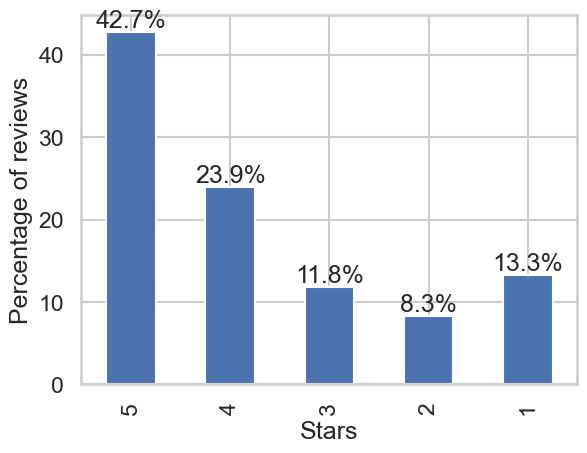

In [ ]:
ax = review_stars_percent.sort_index(ascending=False).plot(kind='bar')
for patch in ax.patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    ax.annotate('{:.1f}%'.format(y), (x.mean(), y), ha='center', va='bottom')
plt.ylabel('Percentage of reviews')
plt.xlabel('Stars');

### 1.2 Reviews-Assessment

In [ ]:
# Filter out unavailable reviews. At least have one vote in all three options.
avai_reviews = reviews.query("useful > 0 and cool > 0 and funny > 0")
print("Number of available reviews: ", len(avai_reviews))

Number of available reviews:  13273


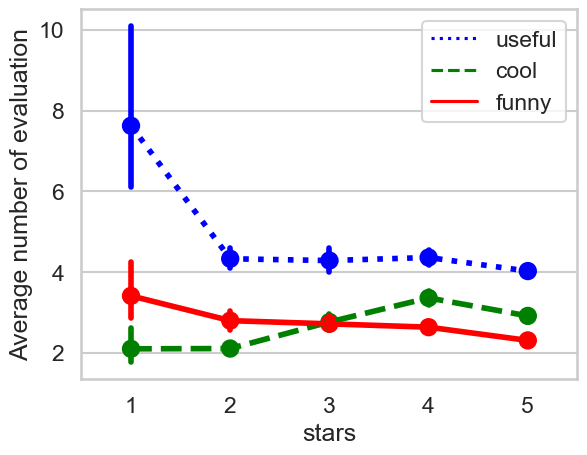

In [ ]:
import matplotlib.lines as mlines
sns.pointplot(x = 'stars', y = 'useful', data = avai_reviews, color="blue", linestyles='dotted')
sns.pointplot(x = 'stars', y = 'cool', data = avai_reviews, color="green", linestyles='--')
sns.pointplot(x = 'stars', y = 'funny', data = avai_reviews, color="red")
lg1 = mlines.Line2D([], [], color='blue', label='useful', linestyle='dotted')
lg2 = mlines.Line2D([], [], color='green', label='cool', linestyle='--')
lg3 = mlines.Line2D([], [], color='red', label='funny')
plt.ylabel('Average number of evaluation')
plt.legend(handles=[lg1, lg2, lg3]);

In the plot we can see that the number of useful votes was always greater than other two.
- For `useful` reviews, the number of `1-star` votes was maximal, nearly twice of other four kinds of stars.
- For `funny` reviews, the more stars people offered, they less votes of `funny` they could get.
- For `cool` reviews, high-star reviews could get more votes.

More votes usually imply that users were more agree with those reviews. Like `useful`, people felt that those `1-star` reviews were more helpful, or furthermore, more reliable. People thought extreme `low-star` reviews can reveal and offer more information about that business. While for `high-star` reviews, customers seemingly held a skeptical attitude, especially comparing with `1-star` review.

### 1.3 Reviews-Sentiment Analysis

It turns out that we can use the words in texts to calculate a measure of the sentiment of the people from their reviews. For example, the sentence "Love coming here" has positive sentiment, whereas the sentence "Food is very bland" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "Love coming here." is more positive than "Like coming here."

I have used the [VADER (Valence Aware Dictionary and Sentiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of users' reviews. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. For example:

In [ ]:
print(''.join(open("vader_lexicon.txt").readlines()[:5]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]



In [ ]:
lexicon = pd.read_csv('vader_lexicon.txt', sep='\t',
                   usecols=[0, 1], header=None, names=['token', 'polarity'],
                   index_col='token')
lexicon.head()

polarity
token          
$:         -1.5
%)         -0.4
%-)        -1.5
&-:        -0.4
&:         -0.7

In [ ]:
lexicon.loc['love']

polarity    3.2
Name: love, dtype: float64

In [ ]:
lexicon.loc['like']

polarity    1.5
Name: like, dtype: float64

I used this lexicon to calculate the overall sentiment for each of review's text. Here's the basic idea:

1. For each review's text, find the sentiment of each word.
2. Calculate the sentiment of each review's text by taking the sum of the sentiments of its words.

Firstly, I converted text to lowercase the text since the lexicon is also lowercase.
And then,  replaced the punctuation with a space since it may fail to match words.

In [ ]:
reviews['text'] = reviews['text'].str.lower()
regex = '[^\w\s]'
reviews['text'] = reviews['text'].apply(lambda text : re.sub(regex, ' ', text))
# Change the review_id as index.
simplify_reviews = reviews[['review_id', 'text']].set_index('review_id')

Secondly, I splitted the text to each word and created a new dataframe. Column `location` means the index of each word in text and `word` is individual word in text.

In [ ]:
words = (
    simplify_reviews['text']
    .str.split(expand=True)
    .stack()
    .reset_index(level=1)
    .rename(columns={'level_1': 'location', 0: 'word'})
)
words.head()

location   word
review_id                              
v0i_UHJMo_hPBq9bxWvW4w         0   love
v0i_UHJMo_hPBq9bxWvW4w         1    the
v0i_UHJMo_hPBq9bxWvW4w         2  staff
v0i_UHJMo_hPBq9bxWvW4w         3   love
v0i_UHJMo_hPBq9bxWvW4w         4    the

Lastly, I merged dataframe `words` with previous `lexicon` dataframe, sum the `polarity` of each word from the same text and added a new column `polarity` to the `reviews`.

In [ ]:
helper = words.reset_index().merge(lexicon.reset_index(), how = 'left', left_on='word', right_on='token')
p = helper.groupby(['review_id']).sum()[['polarity']].reset_index()
reviews = reviews.merge(p, left_on='review_id', right_on='review_id')

# Sort the polarity of review from highest to lowest.
reviews.sort_values('polarity', ascending = False).head()

review_id       date  stars  \
12629  _cLK95Db4mvDwAfOupS7Cw 2016-06-20      4   
7744   QoJAmSEJB2AW46ba56aFRQ 2011-05-01      3   
12600  YGTyhmWf5M1oUeFDAyCwuw 2015-11-23      5   
44351  4n0RFOsAySGiTzKqU3TfdQ 2016-09-05      5   
24855  rKGqy9HKtuO6cSsQANnV-g 2017-08-29      5   

                                                    text  cool  funny  useful  \
12629  i came here yesterday for father s day dinner ...     0      0       3   
7744   5 second summary  mediocre average food  excep...     0      0       1   
12600  i came back to miku for dinner after just comi...     7      1       9   
44351  best new restaurant in henderson and beyond  b...     4      3       5   
24855  a maz ing      i can t say enough great things...     0      0       1   

                  business_id                 user_id  polarity  
12629  -zuJkmIjdRahT_yHED-62g  YMTcBb6Vj54rd_NuFtb8QQ     159.0  
7744   r6CaBBT6oW6laBgkrWbZFQ  XuCbLgo9j1q5dDh9251vkg     145.8  
12600  0a2O150ytxrDjDzXNfRWkA  YMTcBb6Vj54rd_NuFtb8QQ     134.7  
44351  BQqwIYQuo2W94smjrBjy5g  uaC8Ku7fqwD4Gh6L1YabAg     130.0  
24855  4KmrrhtfnngTVFa2d5LAjg  Y7EkNdRl_WCML9zo9lw1nw     129.2

When I plotted the polarity of each review by their received stars, I could see that nearly it makes much sense. For high star reviews they usually had higher polarity and vice versa. But when comparing 4-star with 5-star reviews, their polarities were approximately equal, average polarity of 4-star review was even a little higher than 5-star's. Mostly it was because an outlier with polarity `159` which was maximal in all reviews only gave a 4-star review, and the second highest polarity `145.8` even gave a worse 3-star review.

<Axes: xlabel='stars', ylabel='polarity'>

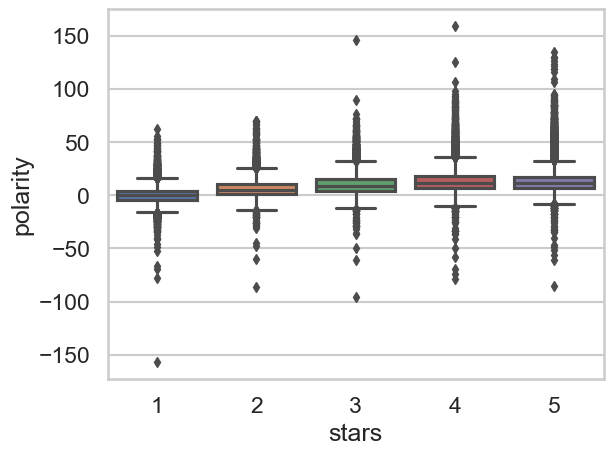

In [ ]:
sns.boxplot(x = 'stars', y = 'polarity', data = reviews)
# y.lim([-50,50]);

In [ ]:
print("Average polarity of 5 star review: ", reviews[reviews['stars'] == 5]['polarity'].mean())
print("Average polarity of 4 star review: ", reviews[reviews['stars'] == 4]['polarity'].mean())
print("Average polarity of 3 star review: ", reviews[reviews['stars'] == 3]['polarity'].mean())
print("Average polarity of 2 star review: ", reviews[reviews['stars'] == 2]['polarity'].mean())
print("Average polarity of 1 star review: ", reviews[reviews['stars'] == 1]['polarity'].mean())

Average polarity of 5 star review:  13.356774344569288
Average polarity of 4 star review:  13.522559317069087
Average polarity of 3 star review:  11.089658677055983
Average polarity of 2 star review:  6.646287158502829
Average polarity of 1 star review:  0.37998040250244974


In [ ]:
reviews1 = reviews[reviews['stars'] != 3]

In [ ]:
reviews1['class'] = reviews1['stars'].apply(lambda x : (1 if x>=4 else 0))
reviews1.head()

review_id       date  stars  \
0  v0i_UHJMo_hPBq9bxWvW4w 2016-05-28      5   
1  vkVSCC7xljjrAI4UGfnKEQ 2016-05-28      5   
2  n6QzIUObkYshz4dz2QRJTw 2016-05-28      5   
3  MV3CcKScW05u5LVfF6ok0g 2016-05-28      5   
4  IXvOzsEMYtiJI0CARmj77Q 2016-05-28      4   

                                                text  cool  funny  useful  \
0  love the staff  love the meat  love the place ...     0      0       0   
1  super simple place but amazing nonetheless  it...     0      0       0   
2  small unassuming place that changes their menu...     0      0       0   
3  lester s is located in a beautiful neighborhoo...     0      0       0   
4  love coming here  yes the place always needs t...     0      0       0   

              business_id                 user_id  polarity  class  
0  0W4lkclzZThpx3V65bVgig  bv2nCi5Qv5vroFiqKGopiw      11.3      1  
1  AEx2SYEUJmTxVVB18LlCwA  bv2nCi5Qv5vroFiqKGopiw       9.7      1  
2  VR6GpWIda3SfvPC-lg9H3w  bv2nCi5Qv5vroFiqKGopiw       6.1      1  
3  CKC0-MOWMqoeWf6s-szl8g  bv2nCi5Qv5vroFiqKGopiw       4.0      1  
4  ACFtxLv8pGrrxMm6EgjreA  bv2nCi5Qv5vroFiqKGopiw       9.4      1

In [ ]:
a = reviews1.sample(500)
jitter_y = a['class'] + 0.1*np.random.rand(len(a['class'])) -0.05
points = go.Scatter(x=a['polarity'], y = jitter_y, mode="markers", marker=dict(opacity=0.5))
py.iplot([points])

### 1.4 Reviews-Keywords

In [ ]:
def keyword_sentiment(keyword1, keyword2):
    sns.displot(reviews[reviews['text'].str.contains(keyword1)]['polarity']) # keyword1
    sns.displot(reviews[reviews['text'].str.contains(keyword2)]['polarity']) # keyword2
    plt.legend([keyword1, keyword2])
    plt.xlim([-50,50]);

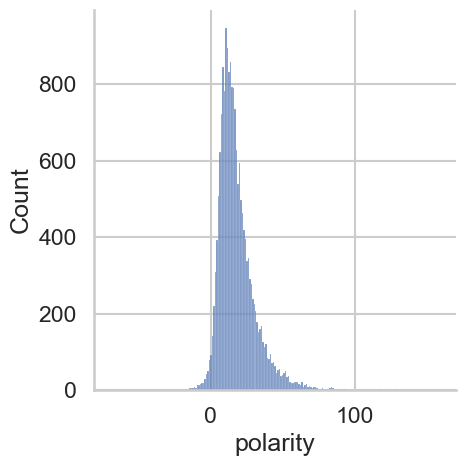

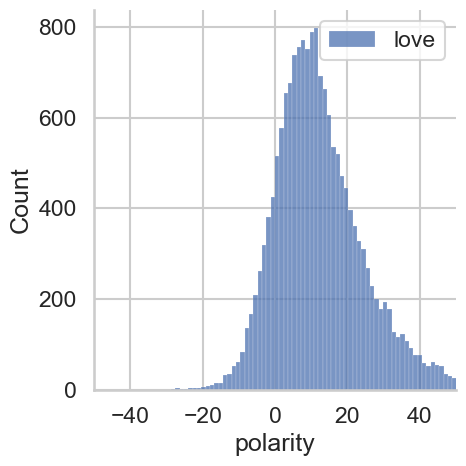

In [ ]:
keyword_sentiment('love', 'wait')

I tried to find if there some certain words that often led to `high-star` reviews. So, I built a dataframe to find out top high-star words. In this part, I focused on businesses whose category contains **Restaurant** and at least have **500** reviews.

In [ ]:
rev = reviews[['review_id', 'stars', 'business_id']]
bus = business[['business_id', 'categories']]
rev_bus = rev.merge(bus, left_on='business_id', right_on='business_id')
rev_bus['restaurant'] = rev_bus['categories'].apply(lambda c : 'Restaurants' in c)
rest = rev_bus[rev_bus['restaurant'] == True]

In [ ]:
top = (words
     .join(rest.set_index('review_id')['stars'])
     .loc[:, ['word', 'stars']]
     .groupby('word')
     .filter(lambda g: len(g) >= 500)
     .groupby('word')
     .median()
     .sort_values('stars', ascending=False)
)

In [ ]:
top[top['stars'] == 5].index

Index(['recommended', 'disappoint', 'appointment', 'equipment', 'haircut',
       'pair', 'hands', 'detail', 'lived', 'absolute', 'absolutely', 'bomb',
       'accommodating', 'amazing', 'courteous', 'knowledgeable', 'fabulous',
       'excellent', 'exceptional', 'professional', 'highly', 'thank', 'thanks',
       'outstanding', 'best', 'salon', 'awesome', 'heaven', 'welcome', 'love',
       'wonderful', 'loved', 'truly', 'incredible', 'phenomenal', 'phoenix',
       'regret', 'az', 'ein', 'personable', 'gorgeous', 'notch', 'perfectly',
       'perfection', 'perfect', 'omg', 'gem', 'greek', 'favorites', 'favorite',
       'delicious', 'delish', 'wow', 'valley', 'town', 'arizona', 'vegan',
       'recommendations', 'fantastic', 'welcoming'],
      dtype='object', name='word')

In [ ]:
top[top['stars'] == 1].index

Index(['upset', 'horrible', 'worse', 'disgusting', 'driver', 'zero',
       'unprofessional', 'receipt', 'awful', 'stylist', 'worst', 'refund',
       'refused', 'manager', 'security', 'insurance', 'rude', 'terrible',
       'situation'],
      dtype='object', name='word')

I could clearly see that most highly positive words are adjectives like `gorgeous`, `exceptional`, `outstanding`, `incredible`, `delicious`, `phenomenal`, some are adverbs which can demonstrate emotions like `absolutely`, `truly`, `perfectly`, and some exclamations such as `omg`, `wow` and so on were always present. In contrast, words that always lead to negative stars were also obvious like `upset`, `worse`, `refund`, etc.

### 1.5 Classifier

It turns out that those keywords can be used reversely to predict whether the star of review is high or low. This is a classification problem, so I used logistic regression to make a classifier. First thing I needed to do was to give each review a label (0 for low, 1 for high) to represent its star, for those with **4-5** review star I counted them as **high-star** reviews, and on the other hand for those with **1-2** stars, I understood them as **low-star** reviews，and I took out all the **3-star** reviews.

In [ ]:
reviews_extremestars = reviews[reviews['stars'] != 3]
reviews_extremestars.shape

(88193, 10)

In [ ]:
reviews_extremestars['high'] = reviews_extremestars['stars'].apply(lambda i : 1 if i > 3 else 0)
reviews_extremestars = reviews_extremestars[['review_id', 'stars', 'text', 'high']]
reviews_extremestars.head()

review_id  stars  \
0  v0i_UHJMo_hPBq9bxWvW4w      5   
1  vkVSCC7xljjrAI4UGfnKEQ      5   
2  n6QzIUObkYshz4dz2QRJTw      5   
3  MV3CcKScW05u5LVfF6ok0g      5   
4  IXvOzsEMYtiJI0CARmj77Q      4   

                                                text  high  
0  love the staff  love the meat  love the place ...     1  
1  super simple place but amazing nonetheless  it...     1  
2  small unassuming place that changes their menu...     1  
3  lester s is located in a beautiful neighborhoo...     1  
4  love coming here  yes the place always needs t...     1

### Train-Test Split

I used the data available for both **training** models and **testing** these models. So I splitted the training data into separate training and test datsets. Then I used this **test data** to evaluate the model once it was done training.

In [ ]:
[train, test] = train_test_split(reviews_extremestars, test_size=0.1, random_state=42)
test.shape

(8820, 4)

### Basic Feature Engineering

In order to take the text of an email and predict whether the text is ham or spam. This is a classification problem, so I used logistic regression to make a classifier. Recall that to train a logistic regression model I need a numeric feature matrix $\Phi$ and corresponding binary labels $Y$. Unfortunately, our data contains text, not numbers. To address this, I created numeric features derived from the email text and use those features for logistic regression.

I created a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It outputs a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does.
For example:

```python
>>> words_in_texts(['hello', 'bye', 'world'],
                   pd.Series(['hello', 'hello world hello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

In [ ]:
def words_in_texts(words, texts):
    return 1 * np.array([texts.str.contains(word) for word in words]).T
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello world hello']))

array([[1, 0, 0],
       [1, 0, 1]])

In [ ]:
def predict(keywords):
    Phi_train = words_in_texts(keywords, train['text'])
    Y_train = train['high']

    lr = sklearn.linear_model.LogisticRegression(fit_intercept=True)
    lr.fit(Phi_train, Y_train)

    training_accuracy = sum(lr.predict(Phi_train) == Y_train) / len(Y_train)
    return training_accuracy

In [ ]:
keywords1 = ['bland', 'awesome', 'love', 'omg', 'delicious']

predict(keywords1)

0.7627404785002456

In [ ]:
train['high'].sum() / len(train)

0.7559623549569753

In [ ]:
keywords2 = ['recommended', 'excellent', 'appointment', 'exceptional', 'absolutely', 'highly',
             'amazing', 'thanks', 'best', 'love', 'courteous', 'accommodating',
             'heaven', 'incredible', 'bomb','security', 'worst', 'refund',
             'awful', 'refused','zero', 'unprofessional', 'rude', 'manager',
             'upset', 'driver', 'worse', 'horrible', 'terrible', 'disgusting']

predict(keywords2)

0.8377533922114573

## Phase 2: Business

In [ ]:
business = business[['business_id', 'name', 'is_open', 'stars', 'review_count', 'categories', 'attributes', 'state', 'city', 'latitude', 'longitude']]
business.head()

business_id                      name  is_open  stars  \
0  FYWN1wneV18bWNgQjJ2GNg          Dental by Design        1    4.0   
1  He-G7vWjzVUysIKrfNbPUQ       Stephen Szabo Salon        1    3.0   
2  KQPW8lFf1y5BT2MxiSZ3QA     Western Motor Vehicle        1    1.5   
3  8DShNS-LuFqpEWIp0HxijA          Sports Authority        0    3.0   
4  PfOCPjBrlQAnz__NXj9h_w  Brick House Tavern + Tap        1    3.5   

   review_count                                         categories  \
0            22  [Dentists, General Dentistry, Health & Medical...   
1            11  [Hair Stylists, Hair Salons, Men's Hair Salons...   
2            18  [Departments of Motor Vehicles, Public Service...   
3             9                         [Sporting Goods, Shopping]   
4           116  [American (New), Nightlife, Bars, Sandwiches, ...   

                                          attributes state            city  \
0  {'AcceptsInsurance': True, 'ByAppointmentOnly'...    AZ       Ahwatukee   
1  {'BusinessParking': {'garage': False, 'street'...    PA        McMurray   
2                                                 {}    AZ         Phoenix   
3  {'BusinessAcceptsCreditCards': True, 'Restaura...    AZ           Tempe   
4  {'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...    OH  Cuyahoga Falls   

    latitude   longitude  
0  33.330690 -111.978599  
1  40.291685  -80.104900  
2  33.524903 -112.115310  
3  33.383147 -111.964725  
4  41.119535  -81.475690

### 2.1 K-means

Businesses tend to appear in clusters, like restaurants. In this phase, I have devised a way to group together restaurants that are close to each other in Las Vegas.

The k-means algorithm must infer clusters from the data. Here, the k-means algorithm finds k centroids within a dataset that each correspond to a cluster of inputs. To do so, k-means begins by choosing k centroids at random, then alternates between the following two steps:

(1)Group the restaurants into clusters, where each cluster contains all restaurants that are closest to the same centroid, and then, (2)compute a new centroid (average position) for each new cluster.

In [ ]:
# Get all the restaurants in Las Vegas.
business['restaurant'] = business['categories'].apply(lambda c : 'Restaurants' in c)
las_vegas_rest = business.query("city == 'Las Vegas' and restaurant == True")
print("Number of restaurants in Las Vegas: ", len(las_vegas_rest))

Number of restaurants in Las Vegas:  1692


Let's load all the restaurants in Las Vegas to an array called `rests` which contains `name`, `position(latitude, longitude)`, `categories`, `stars` and `review_count`.

In [ ]:
rests = utils.load_las_vegas_rest('dataset/business.json')
rests[0]

['Flight Deck Bar & Grill',
 (36.0669136, -115.1708484),
 ['Nightlife',
  'Bars',
  'Barbeque',
  'Sports Bars',
  'American (New)',
  'Restaurants'],
 4.0,
 13]

In [ ]:
# load a Numpy array of (latitude, longitude) pairs
rests_locations = [rest[1] for rest in rests]
fig = gmaps.figure()
rests_layer = gmaps.heatmap_layer(rests_locations)
fig.add_layer(rests_layer)
fig

Figure(layout=FigureLayout(height='420px'))

Use `k-means algorithm` to get six centroids of all the restaurants.

In [ ]:
def k_m(k):
    # Use k-means algorithm
    centroids = kmeans.k_means(rests, k)
    return centroids
k_means_6 = k_m(6) # Get six centroids (latitude, longitude)
k_means_6

[[36.0315460877253, -115.15999583418068],
 [36.1053945968174, -115.11926526213136],
 [36.11299903909825, -115.27899906821801],
 [36.12330128423643, -115.18576419116505],
 [36.22955015928574, -115.25419337377619],
 [36.17542700610727, -115.10805099303342]]

In [ ]:
centroids_layer = gmaps.symbol_layer(k_means_6, fill_color="blue", stroke_color="blue", scale=5)
fig.add_layer(centroids_layer)
fig

Figure(layout=FigureLayout(height='420px'))

### 2.2 Categories

There are many categories in business's `categories` column. What was the most popular category for all the restaurants in **Las Vegas**? Which category had the highest `average-star`? In order to answer these questions, I first filtered out restaurants with `review-count` less than **50**.

In [ ]:
las = las_vegas_rest[las_vegas_rest['review_count'] > 50][['name', 'stars', 'categories']]
las.head()

name  stars  \
54                             GameWorks    3.0   
133  Divine Cafe at the Springs Preserve    4.0   
274                     Trattoria Italia    4.5   
366                              Kinthai    4.5   
621                        Panda Express    2.5   

                                            categories  
54   [Arcades, Arts & Entertainment, Gastropubs, Re...  
133  [Restaurants, Cafes, American (New), Bars, Nig...  
274             [Seafood, Italian, Pizza, Restaurants]  
366                                [Restaurants, Thai]  
621                  [Restaurants, Fast Food, Chinese]

In [ ]:
las['categories'][133]

['Restaurants', 'Cafes', 'American (New)', 'Bars', 'Nightlife', 'Wine Bars']

In [ ]:
def rest_categories_city(l):
    d = {}
    for row in l.index:
        stars = l.loc[row, ]['stars']
        for c in l.loc[row, ]['categories']:
            if c != 'Restaurants':
                if c not in d.keys():
                    d[c] = [stars]
                else:
                    d[c].append(stars)

    rest_categories = pd.DataFrame({'stars':list(d.values())})
    rest_categories.index = d.keys()
    rest_categories['number'] = rest_categories['stars'].apply(lambda a : len(a))
    rest_categories['percentage'] = rest_categories['number'] / len(l) * 100
    rest_categories['average_stars'] = rest_categories['stars'].apply(lambda a : sum(a) / len(a))
    rest_categories = rest_categories.drop(['stars'], axis=1)

    return rest_categories

In [ ]:
rest_from_lasvegas = rest_categories_city(las)
rest_from_lasvegas['city'] = 'Las Vegas'
top10_rest_from_lasvegas = rest_from_lasvegas.sort_values('number', ascending = False).head(10)
top10_rest_from_lasvegas

number  percentage  average_stars       city
Food                       172   21.260816       3.819767  Las Vegas
Nightlife                  141   17.428925       3.716312  Las Vegas
Bars                       136   16.810878       3.727941  Las Vegas
American (Traditional)     119   14.709518       3.462185  Las Vegas
American (New)             102   12.608158       3.735294  Las Vegas
Mexican                     99   12.237330       3.595960  Las Vegas
Breakfast & Brunch          93   11.495674       3.677419  Las Vegas
Pizza                       82   10.135970       3.567073  Las Vegas
Italian                     81   10.012361       3.697531  Las Vegas
Sandwiches                  77    9.517923       3.623377  Las Vegas

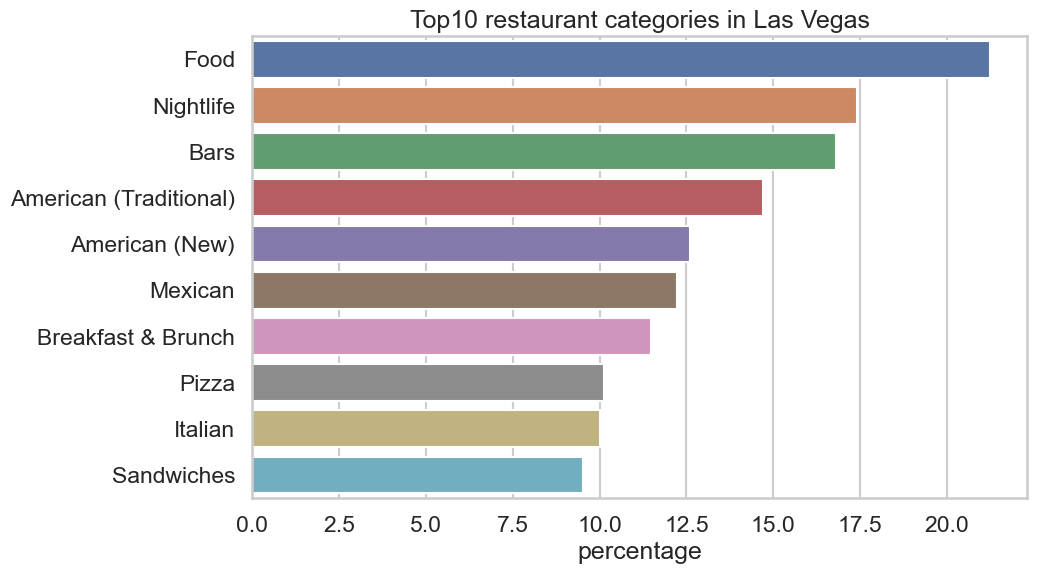

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = 'percentage', y = top10_rest_from_lasvegas.index, data = top10_rest_from_lasvegas)
plt.title('Top10 restaurant categories in Las Vegas');

In [ ]:
p = business.query("city == 'Phoenix' and restaurant == True")
p = p[p['review_count'] > 50][['name', 'stars', 'categories']]
rest_from_phoenix = rest_categories_city(p)
rest_from_phoenix['city'] = 'Phoenix'
top10_rest_from_phoenix = rest_from_phoenix.sort_values('number', ascending = False).head(10) # Top10 in Phoenix

t = business.query("city == 'Toronto' and restaurant == True")
t = t[t['review_count'] > 50][['name', 'stars', 'categories']]
rest_from_toronto = rest_categories_city(t)
rest_from_toronto['city'] = 'Toronto'
top10_rest_from_toronto = rest_from_toronto.sort_values('number', ascending = False).head(10) # Top10 in Toronto

d1 = top10_rest_from_lasvegas.append(top10_rest_from_phoenix)
three_cities_top10 = d1.append(top10_rest_from_toronto)

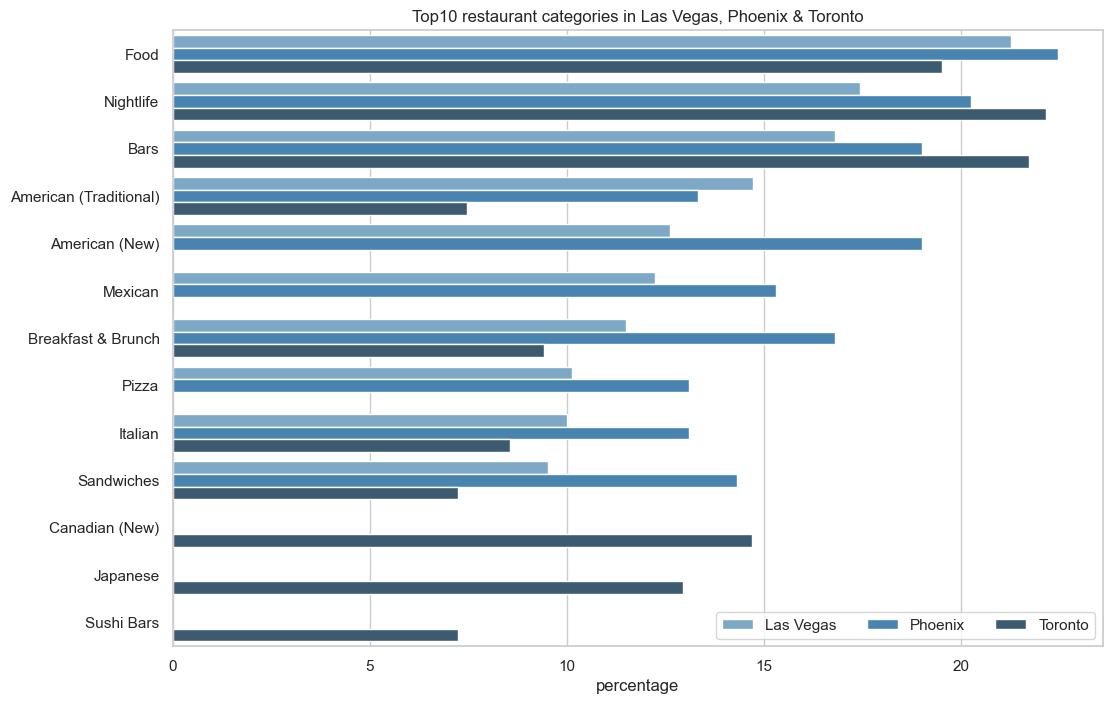

In [ ]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x = 'percentage', y = three_cities_top10.index, hue = 'city', data = three_cities_top10, palette="Blues_d")
ax.legend(ncol=3, loc="lower right", frameon=True)
plt.title("Top10 restaurant categories in Las Vegas, Phoenix & Toronto");

After plotting graphs, I could see that for **Las Vegas** and **Phoenix**, their top10 restaurant categories were exactly same, just a little bit different in proportion sorting. Restaurants about `Nightlife`, `Bars`, with `Sandwiches` and `Pizza` were always popular, and for exotic restaurants people were interested in `Mexican` and `Italian` food.

As for **Toronto**, actually its top10 restaurant categories were nearly identical with them, people still like restaurants about `Nightlife` and `Bars`. Only different part was that `American(new)` restaurants changed to `Canadian(new)` and I understood that people in **Toronto** were more interested in `Japanese` food than `Mexican` food, which resulted in more `Sushi Bars`.

What about `average-star`? Which category had the highest `average-star`? Were they same for different cities? To answer these questions, I analyzed restaurants in **Las Vegas.**

In [ ]:
# Filter out categories showing less than 10 times.
top5_stars_from_lasvegas = rest_from_lasvegas[rest_from_lasvegas['number'] >= 10]\
                            .sort_values('average_stars', ascending = False).head()
top5_stars_from_lasvegas

number  percentage  average_stars       city
Vegan               20    2.472188       4.100000  Las Vegas
Specialty Food      17    2.101360       4.088235  Las Vegas
Korean              19    2.348578       4.052632  Las Vegas
Greek               10    1.236094       4.000000  Las Vegas
Tapas Bars          11    1.359703       4.000000  Las Vegas

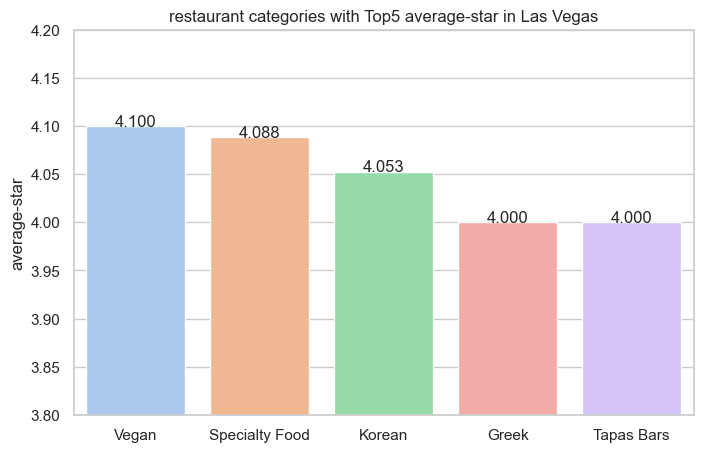

In [ ]:
f, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(y = 'average_stars', x = top5_stars_from_lasvegas.index, data = top5_stars_from_lasvegas, palette="pastel")
plt.ylabel('average-star')
plt.ylim([3.8, 4.2])
for patch in ax.patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    ax.annotate('{:.3f}'.format(y), (x.mean(), y), ha='center')
plt.title('restaurant categories with Top5 average-star in Las Vegas');

In [ ]:
top5_stars_from_phoenix = rest_from_phoenix[rest_from_phoenix['number'] >= 10]\
                            .sort_values('average_stars', ascending = False).head()
top5_stars_from_toronto = rest_from_toronto[rest_from_toronto['number'] >= 10]\
                            .sort_values('average_stars', ascending = False).head()
d1 = top5_stars_from_lasvegas.append(top5_stars_from_phoenix)
three_cities_top5 = d1.append(top5_stars_from_toronto)

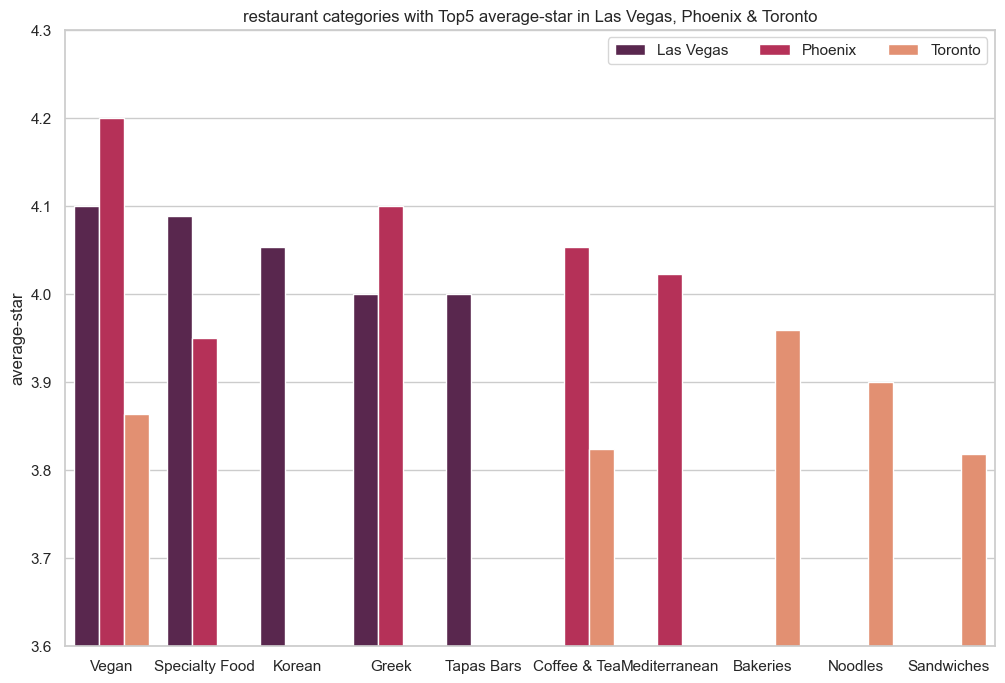

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
sns.barplot(y = 'average_stars', x = three_cities_top5.index, hue = 'city',  data = three_cities_top5, palette="rocket")
plt.ylabel('average-star')
plt.ylim([3.6, 4.30])
ax.legend(ncol=3, loc="upper right", frameon=True)
plt.title('restaurant categories with Top5 average-star in Las Vegas, Phoenix & Toronto');

For three cities, only `Vegan` always had top5 average-star, and others were `Specialty Food`, `Greek` and `Coffee & Tea` which had two cities in top5 average-star. If I extend top5 to top10 average-star of restaurant categories, I found that it still only had `Vegan` in Top5 highest average-star for all three cities.

Was it common for all cities? Were `Vegan` restaurants always so popular?

### 2.3 Vegan Restaurants

In [ ]:
business['vegan'] = business['categories'].apply(lambda c : 'Vegan' in c)
reviews['year'] = reviews['date'].dt.year
rests = business[(business['restaurant'] == True) & (business['is_open'] == 1)]

# We only use the data exists in both reviews dataframe and business dataframe.
rests_with_reviews = reviews.merge(rests, left_on='business_id', right_on='business_id')

In [ ]:
vegan_pect = rests_with_reviews.groupby(['year']).mean()
vegan_pect.reset_index(inplace = True)
vegan_pect['vegan'] = vegan_pect['vegan'] * 100

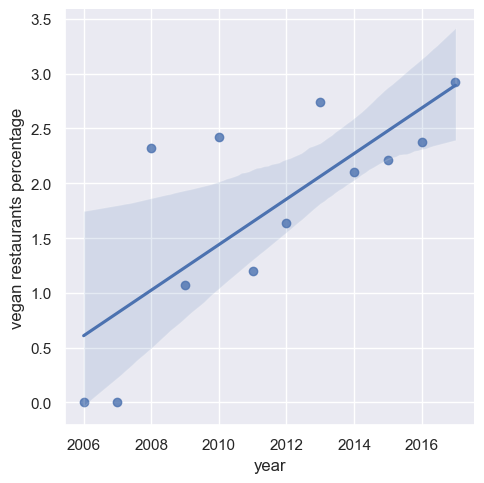

In [ ]:
sns.set(color_codes=True)
sns.lmplot(x = 'year', y = 'vegan', data = vegan_pect)
plt.ylabel('vegan restaurants percentage');

From the plot we can clearly see that the regression model is a positive linear function, which means that the percentage of `Vegan` restaurants number nearly was increasing every year.

We can also compare the `average-star` for `Vegan` restaurants and other categories and it turns out that `Vegan` restaurants were always more well received and reputable.

### 2.4 Attributes

There is a notable column in business dataframe called `attributes`, which contains assorted attributes of that business. In this part, I continued to focus on businesses with `restaurants` category to find out potential connection between attributes and stars.

In [ ]:
business['attributes'][1]

{'BusinessParking': {'garage': False,
  'street': False,
  'validated': False,
  'lot': True,
  'valet': False},
 'HairSpecializesIn': {'coloring': True,
  'africanamerican': False,
  'curly': True,
  'perms': True,
  'kids': True,
  'extensions': True,
  'asian': True,
  'straightperms': True},
 'BusinessAcceptsCreditCards': True,
 'RestaurantsPriceRange2': 3,
 'GoodForKids': True,
 'ByAppointmentOnly': False,
 'WheelchairAccessible': True}

In [ ]:
def get_rests_from_attributes(*args):
    partof_rests = pd.DataFrame({'business_id':rests['business_id'], 'name':rests['name'], 'stars':rests['stars']})
    def helper(attribute):
        attributes = []
        for a in rests['attributes']:
            if attribute in a.keys():
                attributes.append(a[attribute])
            else:
                attributes.append(None)
        return attributes

    for i in range(len(args)):
        attribute = args[i]
        partof_rests[attribute.lower()] = helper(attribute)

    return partof_rests

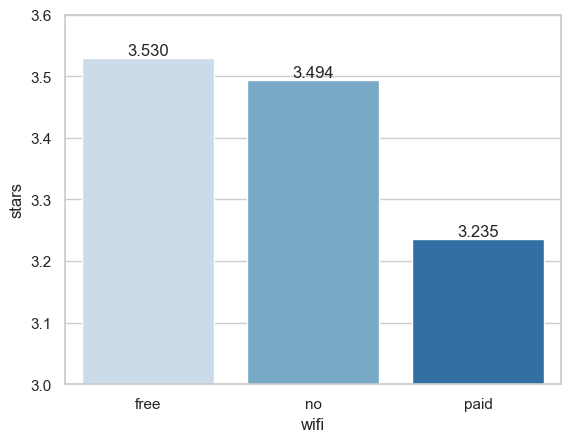

In [ ]:
star_with_wifi = get_rests_from_attributes('WiFi').groupby(['wifi']).mean().reset_index()
sns.set(style="whitegrid")
ax = sns.barplot(x = 'wifi', y = 'stars', data = star_with_wifi, palette = 'Blues')
for patch in ax.patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    ax.annotate('{:.3f}'.format(y), (x.mean(), y), ha='center', va='bottom')
plt.ylim([3, 3.6]);

From the plot above, it becomes clear that restaurants with `free` wifi can get higher stars while with `paid` wifi they usuallly will get lower stars, even much worse than restaurants `without` wifi service.

I added another attribute called `NoiseLevel` and plotted the average stars.

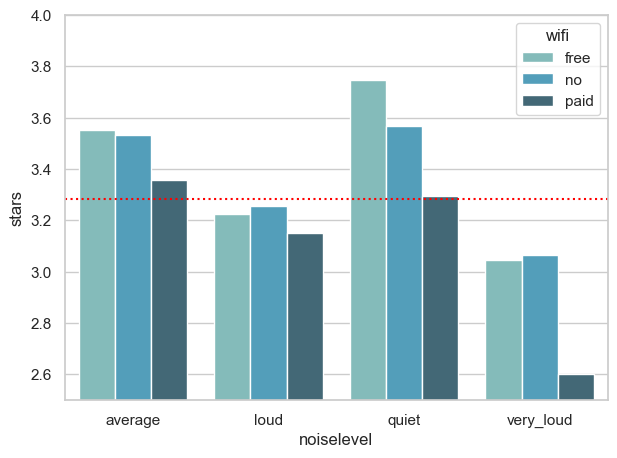

In [ ]:
star_with_wifiandnoise = get_rests_from_attributes('NoiseLevel', 'WiFi').groupby(['noiselevel', 'wifi']).mean().reset_index()
f, ax = plt.subplots(figsize=(7, 5))
ax = sns.barplot(x = 'noiselevel', y = 'stars', hue = 'wifi', data = star_with_wifiandnoise, palette = 'GnBu_d')
ax.axhline(
    y=star_with_wifiandnoise['stars'].mean(),
    color='red',
    linestyle='dotted'
)
plt.ylim([2.5, 4]);

Red dotted line is the average stars from all the reviews, and we can see that for restaurants with `loud` or `very loud` noise, their average stars were always lower than mean no matter how good their wifi service were, and basically it follows `quiet` > `average` > `loud` > `very loud`.

For many customers drive to restaurants, one realistic problem is that if there is available parking place for them. In the attributes there is one called `BusinessParking` which contains five different kinds of parking place of that restaurant.

In [ ]:
columnsname = ['garage', 'street', 'validated', 'lot', 'valet']
def get_rests_from_attributes2(attribute):
    partof_rests = pd.DataFrame({'business_id':rests['business_id'], 'name':rests['name'], 'stars':rests['stars']})
    def helper(park, kind):
        if kind in park.keys():
            return park[kind]
        else:
            return False
    for i in columnsname:
        c = []
        for a in rests['attributes']:
            if attribute in a.keys():
                c.append(helper(a[attribute], i))
            else:
                c.append(False) # Set default to False
        partof_rests[i] = c
    return partof_rests
rests_parking = get_rests_from_attributes2('BusinessParking')
rests_parking.head()

business_id                        name  stars  garage  street  \
4   PfOCPjBrlQAnz__NXj9h_w    Brick House Tavern + Tap    3.5   False   False   
5   o9eMRCWt5PkpLDE0gOPtcQ                     Messina    4.0   False   False   
14  fNMVV_ZX7CJSDWQGdOM8Nw  Showmars Government Center    3.5   False   False   
19  Gu-xs3NIQTj3Mj2xYoN2aw   Maxim Bakery & Restaurant    3.5   False   False   
25  1K4qrnfyzKzGgJPBEcJaNQ      Chula Taberna Mexicana    3.5   False    True   

    validated    lot  valet  
4       False   True  False  
5       False  False  False  
14      False  False  False  
19      False   True  False  
25      False  False  False

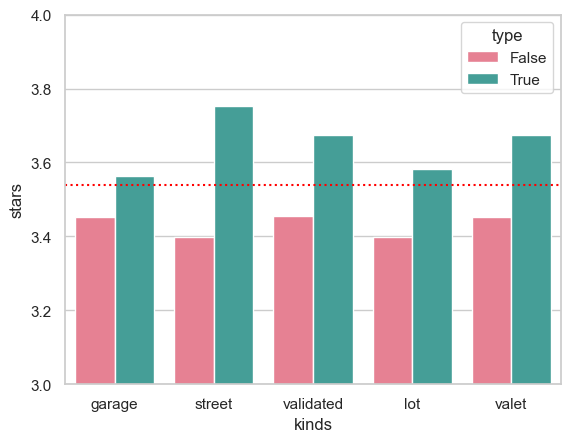

In [ ]:
star_with_parking = pd.DataFrame()
for c in columnsname:
    p = rests_parking.groupby([c]).mean().reset_index()
    star_with_parking = star_with_parking.append(pd.DataFrame({'kinds':[c, c], 'type':p[c], 'stars':p['stars']}))

sns.barplot(x = 'kinds', y = 'stars', hue = 'type', data = star_with_parking, palette = 'husl')
plt.axhline(
    y=star_with_parking['stars'].mean(),
    color='red',
    linestyle='dotted'
)
plt.ylim([3, 4]);

Well, I could figure out that for all five different parking places possessing them were always better than without them. And among them looks like restaurants with `roadside` parking space usually had higher-star reviews, but restaurants with `valet` or `garage`, surprisingly, did not have pretty higher-star reviews.

### 2.5 Finding ideal location for a new restaurant

In [ ]:
postal_code1 = input('Which zip code are you planning to expand your restaurant in? ')

Which zip code are you planning to expand your restaurant in? 89146


In [ ]:
category1 = input('What is the category of your restaurant? ')

What is the category of your restaurant? Japanese


In [ ]:
def tp_fun(path):
    """Create restaurant objects."""
    with open(path) as file:
        restaurant_data = [json.loads(obj) for obj in file]
    bus_to_rest = {}
    for restaurant in restaurant_data:
        categories = restaurant['categories']
        if restaurant['postal_code'] == postal_code1 and 'Restaurants' in categories and category1 in categories and restaurant['stars']>3.0:
            name = restaurant['name']
            location = float(restaurant['latitude']), float(restaurant['longitude'])
            stars = restaurant['stars']
            num_reviews = restaurant['review_count']
            business_id = restaurant['business_id']
            restaurant = [name, location, categories, stars, num_reviews]
            bus_to_rest[business_id] = restaurant
    return list(bus_to_rest.values())


In [ ]:
locan = tp_fun('dataset/business.json')
locan

[['Swish Shabu Shabu',
  (36.1261008, -115.211285),
  ['Hot Pot', 'Sushi Bars', 'Japanese', 'Restaurants', 'Fondue'],
  3.5,
  386],
 ['Sushi Yamaguchi',
  (36.1599319, -115.2222054),
  ['Japanese', 'Sushi Bars', 'Restaurants'],
  4.0,
  36],
 ["Mom's Teriyaki",
  (36.1433289011, -115.225409344),
  ['Asian Fusion', 'Restaurants', 'Hawaiian', 'Japanese'],
  4.5,
  98],
 ['Ramen Hashi',
  (36.1260798, -115.2215303),
  ['Restaurants', 'Japanese', 'Ramen'],
  4.5,
  87],
 ['Kaba Curry',
  (36.125587, -115.211199),
  ['Hawaiian', 'Asian Fusion', 'Japanese', 'Restaurants'],
  4.0,
  91],
 ['Monta Ramen',
  (36.1270336, -115.2096821),
  ['Restaurants', 'Noodles', 'Ramen', 'Japanese'],
  4.0,
  2291],
 ['Sakura Japanese Cuisine',
  (36.1271919, -115.2414116),
  ['Restaurants', 'Food', 'Japanese'],
  4.0,
  24],
 ['Kikuhana Japanese Restaurant',
  (36.1433639, -115.2424505),
  ['Japanese', 'Restaurants'],
  3.5,
  4],
 ['Lucky Fish Sushi & Grill',
  (36.127754, -115.224318),
  ['Japanese', 'Sus

In [ ]:
locan[0]

['Swish Shabu Shabu',
 (36.1261008, -115.211285),
 ['Hot Pot', 'Sushi Bars', 'Japanese', 'Restaurants', 'Fondue'],
 3.5,
 386]

In [ ]:
final_loc = [loca[1] for loca in locan]
fig = gmaps.figure()
res_layer = gmaps.heatmap_layer(final_loc)
fig.add_layer(res_layer)
fig

Figure(layout=FigureLayout(height='420px'))

## Conclusion

•	Maximum number reviews means maximum exposure to customer problems and the factors that make customers happy.

•	In the month with maximum reviews, restaurants should focus on their service more as that will affect their reputation drastically.

•	Trying to compete in favorite restaurant categories is difficult, but it also gives you more customer base as a greater number of people prefer those categories.

•	Being a popular state on yelp simply means that it has maximum number of businesses. To maximize profits, one should focus on their business type and gather information with that perspective. For example, if the business type is restaurants, one should focus on cities like ‘Las Vegas’ as it has lots of restaurants.


•	Restaurant owners should focus on getting the trending type of reviews for example ‘cool’ in this dataset as it will get the restaurant good ratings and eventually be beneficial for the business in the long term.

•	Attributes of the restaurant like roadside parking, free WIFI, quiet restaurant, etc. play a vital role in getting good reviews and make it easy restaurant to be well received.

•	Area of the restaurant make a huge difference for people’s choices of food. For example, Sushi might be favorite category in Japan, but it might not be the same case in Canada or US. Hence restaurant should focus on universally accepted restaurants like vegan restaurants.

•	Ideal location for restaurant might be considered and a good recommendation but ultimately, it depends on the business strategy the restaurant wants to opt for. It might be a good idea for some restaurants to open a branch at a location where many similar restaurants exist, but for others, it might be good if they open the branch at a farther location.

NYC, locations, different locations depend on different data sets, you can't completely rely on yelp data.

As it is skewed in those cetain locations

No information about traffic at locations